<a href="https://colab.research.google.com/github/MancheelaNithinkumar/FMML_Project_and_Labs/blob/main/Module_7_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Module 7 Project: Movie Recommendation Engine

`Module Coordinator: Ganesh Chandan`

In this module, we will try to create a Movie Recommendation System using different unsupervised learning techniques.

In [1]:
# dataset download

# !wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-02-09 06:26:54--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   784KB/s    in 1.2s    

2025-02-09 06:26:56 (784 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Clustering based recommendation

In [2]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
# Import the Movies dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Import the ratings dataset
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [6]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)

        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)

    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


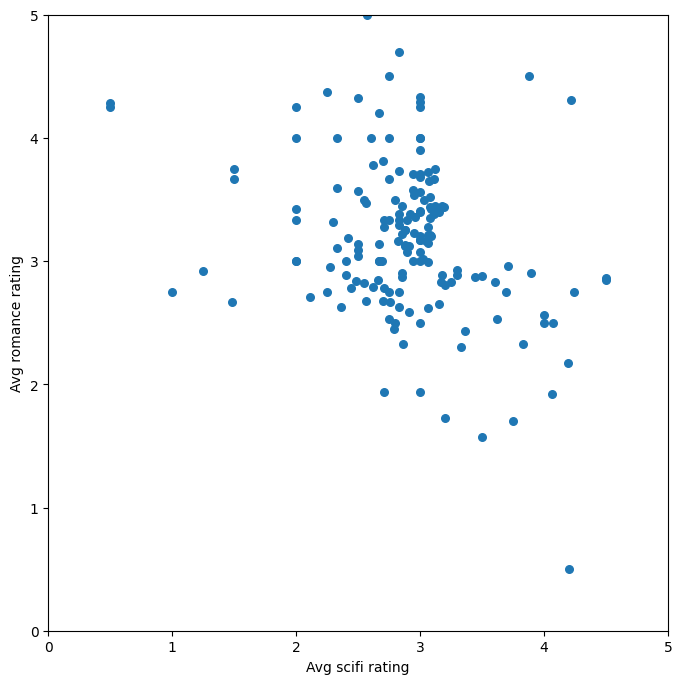

In [8]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

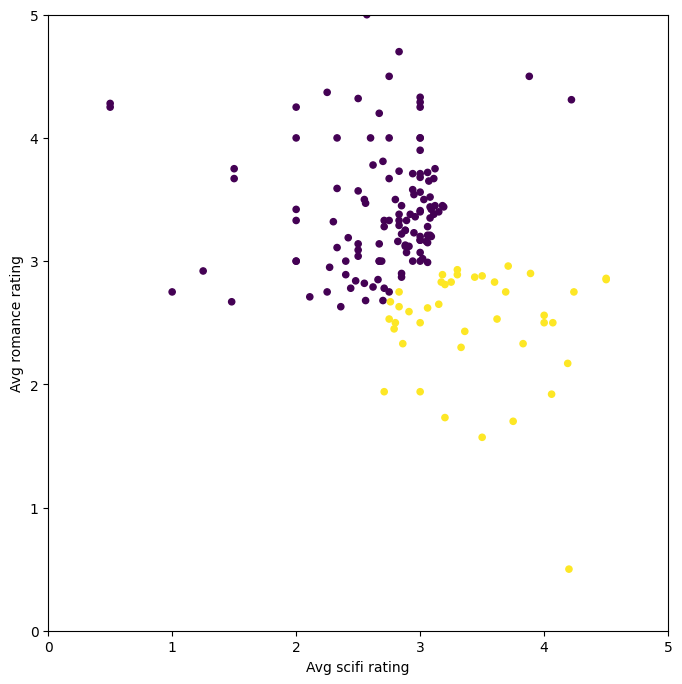

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

# Import KMeans
from sklearn.cluster import KMeans

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

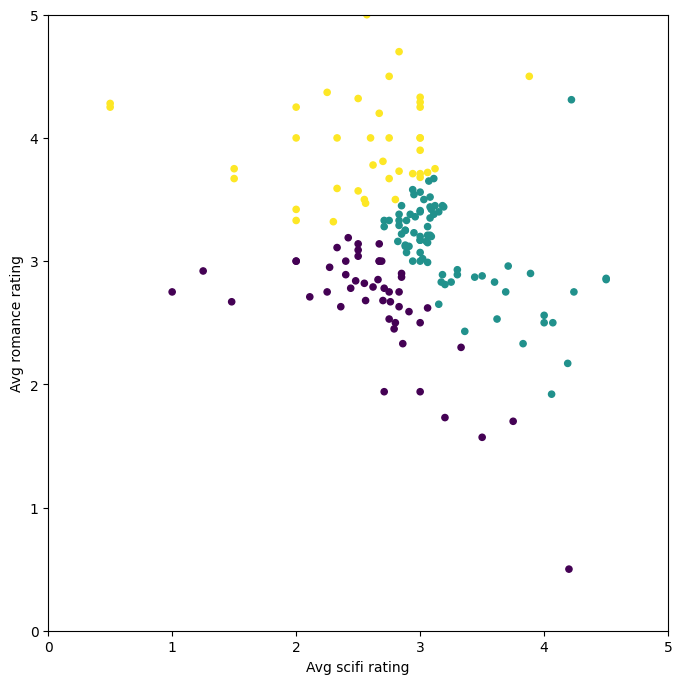

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

It is evident now that the science-fiction rating has started to come into play:

    People who like sci-fi and romance modeately belong to the green group.
    People who like scifi but not romance belong to the yello group.
    People who like romance but not sci-fi belong to the purple group.

Finding optimal clusters using silhouette score

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


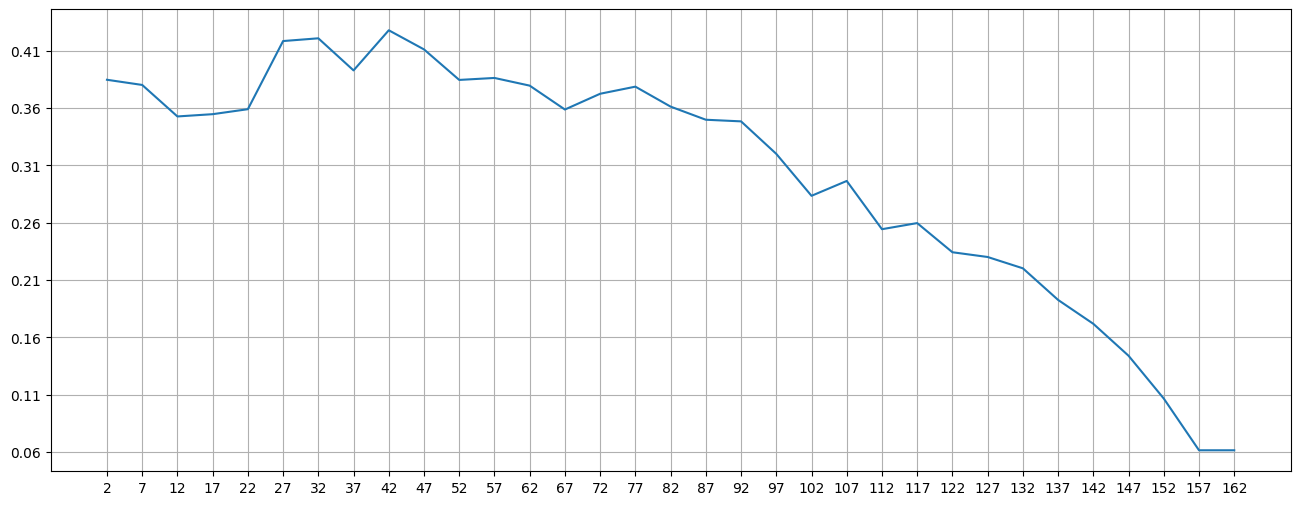

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



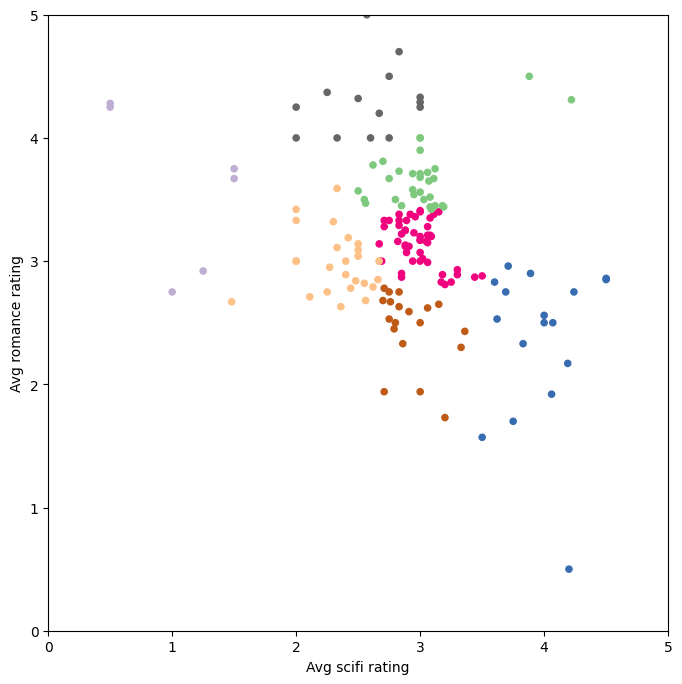

In [12]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [13]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


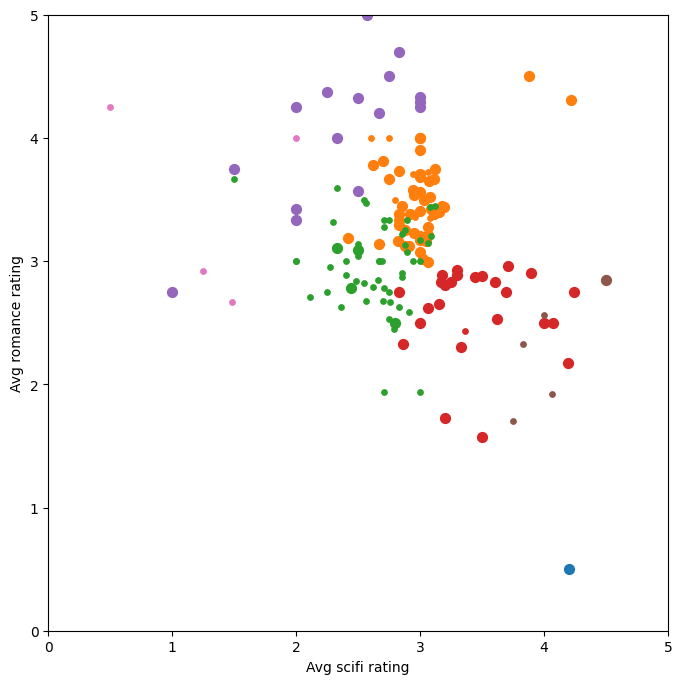

In [14]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating','avg_romance_rating','avg_action_rating']].values# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3:
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'],
                        point['avg_romance_rating'],
                        s=size,
                        color=color)# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

The size of the dots represent the ratings of the action movies.

# Exercise 1

## Instead of choosing a n_clusters as 7, play around with different k
## Find the optimal no of clusters with 3 genre_ratings data we just created using silhouette score method

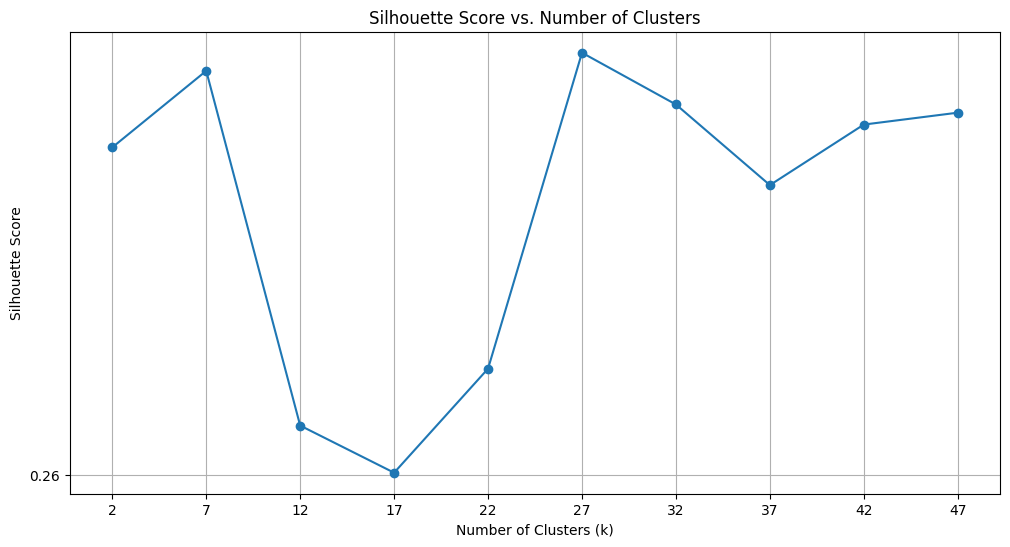

The optimal number of clusters (k) is: 27


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Selecting our dataset to study
X = biased_dataset_3_genres[['avg_scifi_rating', 'avg_romance_rating', 'avg_action_rating']].values

# Choose the range of k values to test.
# We added a stride of 5 to improve performance.
possible_k_values = range(2, min(len(X), 50) + 1, 5)  # Limit max k to avoid excessive computation

# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(data)  # Added random_state for reproducibility
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

# Plot each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(possible_k_values, errors_per_k, marker='o', linestyle='-')

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values) + 1, 5)
ax.set_xticks(xticks)
ax.xaxis.grid(True, which='both')

yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), 0.05)
ax.set_yticks(yticks)
ax.yaxis.grid(True, which='both')

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

# Identify the optimal k
optimal_k = possible_k_values[errors_per_k.index(max(errors_per_k))]
print(f"The optimal number of clusters (k) is: {optimal_k}")


### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
import pandas as pd

# Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # Count ratings per movie (non-null values)
    movie_rating_counts = user_movie_ratings.count()

    # Sort movies based on rating count (descending order)
    most_rated_movies = user_movie_ratings.loc[:, movie_rating_counts.sort_values(ascending=False).index]

    # Keep only the top `max_number_of_movies`
    most_rated_movies = most_rated_movies.iloc[:, :max_number_of_movies]

    return most_rated_movies

# Function to get users who have rated the most movies
def get_users_who_rate_the_most(most_rated_movies, n_users):
    # Count the number of ratings per user (row-wise non-null values)
    most_rated_movies["num_ratings"] = most_rated_movies.notnull().sum(axis=1)

    # Sort users by the number of ratings in descending order
    most_rated_movies = most_rated_movies.sort_values(by="num_ratings", ascending=False)

    # Select the top `n_users`
    most_rated_movies = most_rated_movies.iloc[:n_users, :]

    # Drop the extra column used for sorting
    most_rated_movies = most_rated_movies.drop(columns=["num_ratings"])

    return most_rated_movies

# Function to sort by rating density
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# Choose the number of movies and users
n_movies = 30
n_users = 18

# Sample dataset
data = {
    "Movie1": [5, 4, None, 3, None],
    "Movie2": [4, None, 5, 2, 3],
    "Movie3": [None, 3, None, 5, 4],
    "Movie4": [3, 4, 2, None, None],
    "Movie5": [None, None, 4, 5, 3],
}

# Convert dictionary to Pandas DataFrame
user_movie_ratings = pd.DataFrame(data)

# Apply sorting function
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

# Print results
print('Dataset dimensions:', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())


Dataset dimensions: (5, 5)
   Movie2  Movie1  Movie3  Movie4  Movie5
3     2.0     3.0     5.0     NaN     5.0
0     4.0     5.0     NaN     3.0     NaN
1     NaN     4.0     3.0     4.0     NaN
2     5.0     NaN     NaN     2.0     4.0
4     3.0     NaN     4.0     NaN     3.0


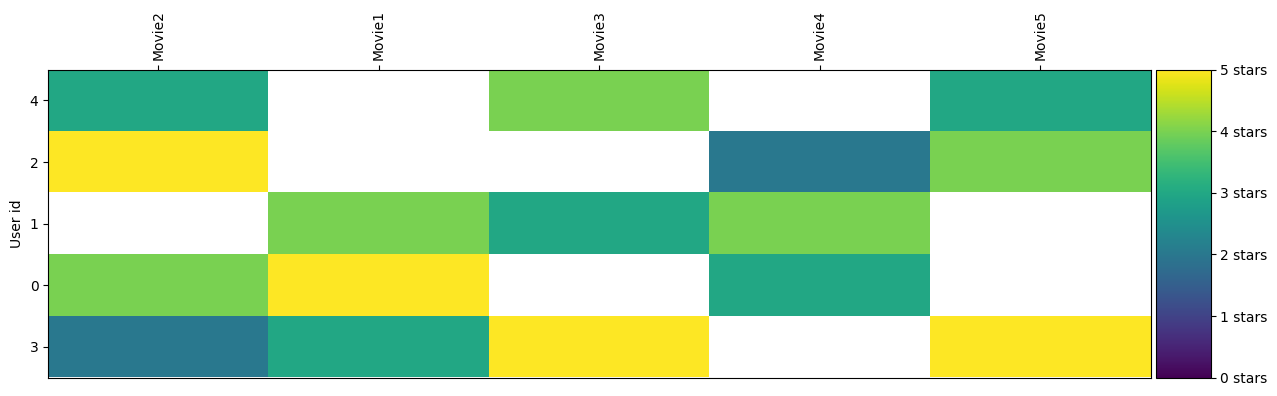

In [19]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):

    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()

    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    ax.grid(False)
    ax.set_ylabel('User id')# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [20]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [21]:
from scipy import sparse

# Conversion to sparse csr matrix
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

### Large Scale Clustering

In [23]:
# Perform K-Means clustering (20 clusters)
predictions = KMeans(n_clusters=20, algorithm='lloyd', random_state=42).fit_predict(sparse_ratings)

# Add the cluster assignments to the movie data
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(), pd.DataFrame({'group': predictions})], axis=1)

# Print the first few rows of the clustered DataFrame
print(clustered.head())

# Optionally, visualize the clusters (uncomment to visualize)
# draw_movie_clusters(clustered, max_users=20, max_movies=20)

   userId  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
0       1                  4.0                               NaN   
1       2                  NaN                               3.0   
2       3                  NaN                               NaN   
3       4                  NaN                               NaN   
4       5                  NaN                               3.0   

   Pulp Fiction (1994)  Silence of the Lambs, The (1991)  Matrix, The (1999)  \
0                  3.0                               4.0                 5.0   
1                  NaN                               NaN                 NaN   
2                  NaN                               NaN                 NaN   
3                  1.0                               5.0                 1.0   
4                  5.0                               NaN                 NaN   

   Star Wars: Episode IV - A New Hope (1977)  Jurassic Park (1993)  \
0                                       

### Predictions and Recommendation

In [25]:
# Pick a cluster ID from the clusters above
cluster_number = 11

# Let's filter to only see the region of the dataset with the most number of values
n_users = 75
n_movies = 300

# Reset index to avoid 'index' column issues and ensure correct columns
clustered_reset = clustered.reset_index(drop=True)

# Filter the data for the specific cluster and drop unnecessary columns
cluster = clustered_reset[clustered_reset['group'] == cluster_number].drop(['group'], axis=1)

print(cluster)

# Sort and print the cluster
cluster = sort_by_rating_density(cluster, n_movies, n_users)

# Visualize the heatmap (uncomment if desired)
# draw_movies_heatmap(cluster, axis_labels=False)

     userId  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
18       19                  2.0                               NaN   
56       57                  4.0                               NaN   
155     156                  3.0                               4.5   
198     199                  2.0                               4.0   
201     202                  5.0                               4.0   
216     217                  2.0                               NaN   
220     221                  3.5                               4.0   
265     266                  4.0                               NaN   
274     275                  3.0                               4.0   
289     290                  NaN                               5.0   
461     462                  2.5                               4.0   
468     469                  NaN                               5.0   
554     555                  5.0                               5.0   
596     597         

In [26]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

3.8076923076923075

In [27]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

,0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),4.400000
userId,305.866667
L.A. Confidential (1997),4.428571
Blade Runner (1982),4.321429
Star Wars: Episode IV - A New Hope (1977),4.142857
Reservoir Dogs (1992),4.285714
Shakespeare in Love (1998),3.250000
Ferris Bueller's Day Off (1986),4.038462
"Fish Called Wanda, A (1988)",4.230769
Back to the Future (1985),3.461538


In [28]:
cluster

,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),userId,L.A. Confidential (1997),Blade Runner (1982),Star Wars: Episode IV - A New Hope (1977),Reservoir Dogs (1992),Shakespeare in Love (1998),Ferris Bueller's Day Off (1986),"Fish Called Wanda, A (1988)",Back to the Future (1985),...,Monty Python's And Now for Something Completely Different (1971),Wallace & Gromit: The Wrong Trousers (1993),"Godfather: Part III, The (1990)",Mary Poppins (1964),Air Force One (1997),Blade (1998),Hoop Dreams (1994),Better Off Dead... (1985),Willy Wonka & the Chocolate Factory (1971),"Bridge on the River Kwai, The (1957)"
468,4.0,469,5.0,5.0,4.0,5.0,4.0,4.0,5.0,3.0,...,5.0,NaN,3.0,4.0,NaN,NaN,NaN,4.0,5.0,4.0
602,4.0,603,5.0,3.0,4.0,5.0,2.0,4.0,4.0,2.0,...,NaN,NaN,2.0,4.0,NaN,4.0,4.0,NaN,3.0,NaN
56,5.0,57,5.0,5.0,5.0,NaN,5.0,5.0,3.0,4.0,...,4.0,5.0,3.0,4.0,3.0,NaN,NaN,3.0,NaN,5.0
596,5.0,597,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,...,NaN,5.0,3.0,NaN,3.0,NaN,5.0,5.0,5.0,NaN
18,5.0,19,4.0,4.0,4.0,3.0,4.0,5.0,4.0,4.0,...,2.0,4.0,NaN,2.0,NaN,3.0,NaN,3.0,4.0,NaN
201,5.0,202,4.0,5.0,4.0,5.0,4.0,4.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,3.0,5.0,NaN,NaN,NaN
216,5.0,217,3.0,NaN,5.0,3.0,2.0,3.0,3.0,3.0,...,NaN,4.0,NaN,NaN,4.0,2.0,NaN,NaN,3.0,NaN
554,4.0,555,NaN,4.0,5.0,5.0,2.0,4.0,NaN,3.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN
155,4.0,156,5.0,4.0,1.0,4.0,4.0,3.0,4.0,3.5,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
274,4.0,275,4.0,5.0,4.0,5.0,4.0,5.0,5.0,4.0,...,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN


In [29]:


# Pick a user ID from the dataset
user_id = 7

# Check if user_id exists in the index
if user_id in cluster.index:
    # Get all this user's ratings
    user_2_ratings = cluster.loc[user_id, :]

    # Which movies did they not rate?
    user_2_unrated_movies = user_2_ratings[user_2_ratings.isnull()]

    # What are the ratings of these movies the user did not rate?
    avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:, 0]

    # Sort by rating so the highest rated movies are presented first
    print(avg_ratings.sort_values(ascending=False)[:20])
else:
    print(f"User ID {user_id} does not exist in the cluster DataFrame.")


User ID 7 does not exist in the cluster DataFrame.


## Using Collaborative Filtering (With fast.ai)

In [30]:
! [ -e /content ] && pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.7 MB/s eta 0:00:00


In [31]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [32]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [33]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [34]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [35]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,186,302,3,L.A. Confidential (1997)
2,22,377,1,Heavyweights (1994)
3,244,51,2,Legends of the Fall (1994)
4,166,346,1,Jackie Brown (1997)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [36]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [37]:
dls.show_batch()

,user,title,rating
0,371,Forrest Gump (1994),5
1,864,In the Name of the Father (1993),4
2,312,M*A*S*H (1970),4
3,752,"Big Lebowski, The (1998)",5
4,537,Cyrano de Bergerac (1990),4
5,312,Star Wars (1977),5
6,921,Willy Wonka and the Chocolate Factory (1971),3
7,817,Air Force One (1997),3
8,886,Home Alone (1990),4
9,193,Liar Liar (1997),1


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [38]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [39]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.883890,0.957188,00:10
1,0.690048,0.896200,00:13
2,0.528759,0.873318,00:08
3,0.449593,0.857608,00:08
4,0.430949,0.854191,00:08


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

### Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [40]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [41]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [42]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [43]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.2929), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2794),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2673), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2572),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2542), 'Spice World (1997)', 2.1153846153846154),
 (tensor(-0.2538), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2467), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2425), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.2337), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2328), 'Anaconda (1997)', 2.289473684210526),
 (tensor(-0.2316), 'Booty Call (1997)', 2.1666666666666665),
 (tensor(-0.2301), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2292), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2280), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2193), 'Leave It to Beaver (1997)', 1.8409090909

Or the ones with the best bias:

In [44]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5848), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5758), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5707), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5555), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5089), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5032), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4957), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4880), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4751), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.4742), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4740), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4527), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4507), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4448), 'Fugitive, The (1993)', 4.044642857142857),
 (tensor(0.4444), 'L.A. Confidential (1997)', 4.161616161616162)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [45]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [46]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [47]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2505), 'Home Alone 3 (1997)'),
 (tensor(1.2223), "McHale's Navy (1997)"),
 (tensor(1.1488), 'Bio-Dome (1996)'),
 (tensor(1.1361), 'Congo (1995)'),
 (tensor(1.1100), 'Flipper (1996)'),
 (tensor(1.1050), 'Children of the Corn: The Gathering (1996)'),
 (tensor(1.0945), 'Jungle2Jungle (1997)'),
 (tensor(1.0642), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.0582), 'Spice World (1997)'),
 (tensor(1.0248), 'Leave It to Beaver (1997)')]

And the worst:

In [49]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0917), 'Wrong Trousers, The (1993)'),
 (tensor(-1.0363), 'Fargo (1996)'),
 (tensor(-1.0132), 'Godfather, The (1972)'),
 (tensor(-1.0029), 'Casablanca (1942)'),
 (tensor(-1.0000), 'Eat Drink Man Woman (1994)'),
 (tensor(-0.9858), 'Chinatown (1974)'),
 (tensor(-0.9696), 'Third Man, The (1949)'),
 (tensor(-0.9663), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(-0.9572), 'Secrets & Lies (1996)'),
 (tensor(-0.9428), "One Flew Over the Cuckoo's Nest (1975)")]

Same thing for our second dimension:

In [50]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [51]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8785), 'Pallbearer, The (1996)'),
 (tensor(0.8559), 'Jude (1996)'),
 (tensor(0.8525), 'Road to Wellville, The (1994)'),
 (tensor(0.7867), 'Cable Guy, The (1996)'),
 (tensor(0.7809), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7710), 'Stuart Saves His Family (1995)'),
 (tensor(0.7587), 'Lost Highway (1997)'),
 (tensor(0.7547), 'Brazil (1985)'),
 (tensor(0.7542), 'Mighty Aphrodite (1995)'),
 (tensor(0.7476), 'Serial Mom (1994)')]

In [52]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1164), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9997), 'Braveheart (1995)'),
 (tensor(-0.9848), 'Indiana Jones and the Last Crusade (1989)'),
 (tensor(-0.9299), 'Forrest Gump (1994)'),
 (tensor(-0.8786), 'Phenomenon (1996)'),
 (tensor(-0.8447), 'Back to the Future (1985)'),
 (tensor(-0.8366), 'American President, The (1995)'),
 (tensor(-0.8212), "It's a Wonderful Life (1946)"),
 (tensor(-0.8074), 'Lion King, The (1994)'),
 (tensor(-0.8004), 'Independence Day (ID4) (1996)')]

And we can even plot the movies according to their scores on those dimensions:

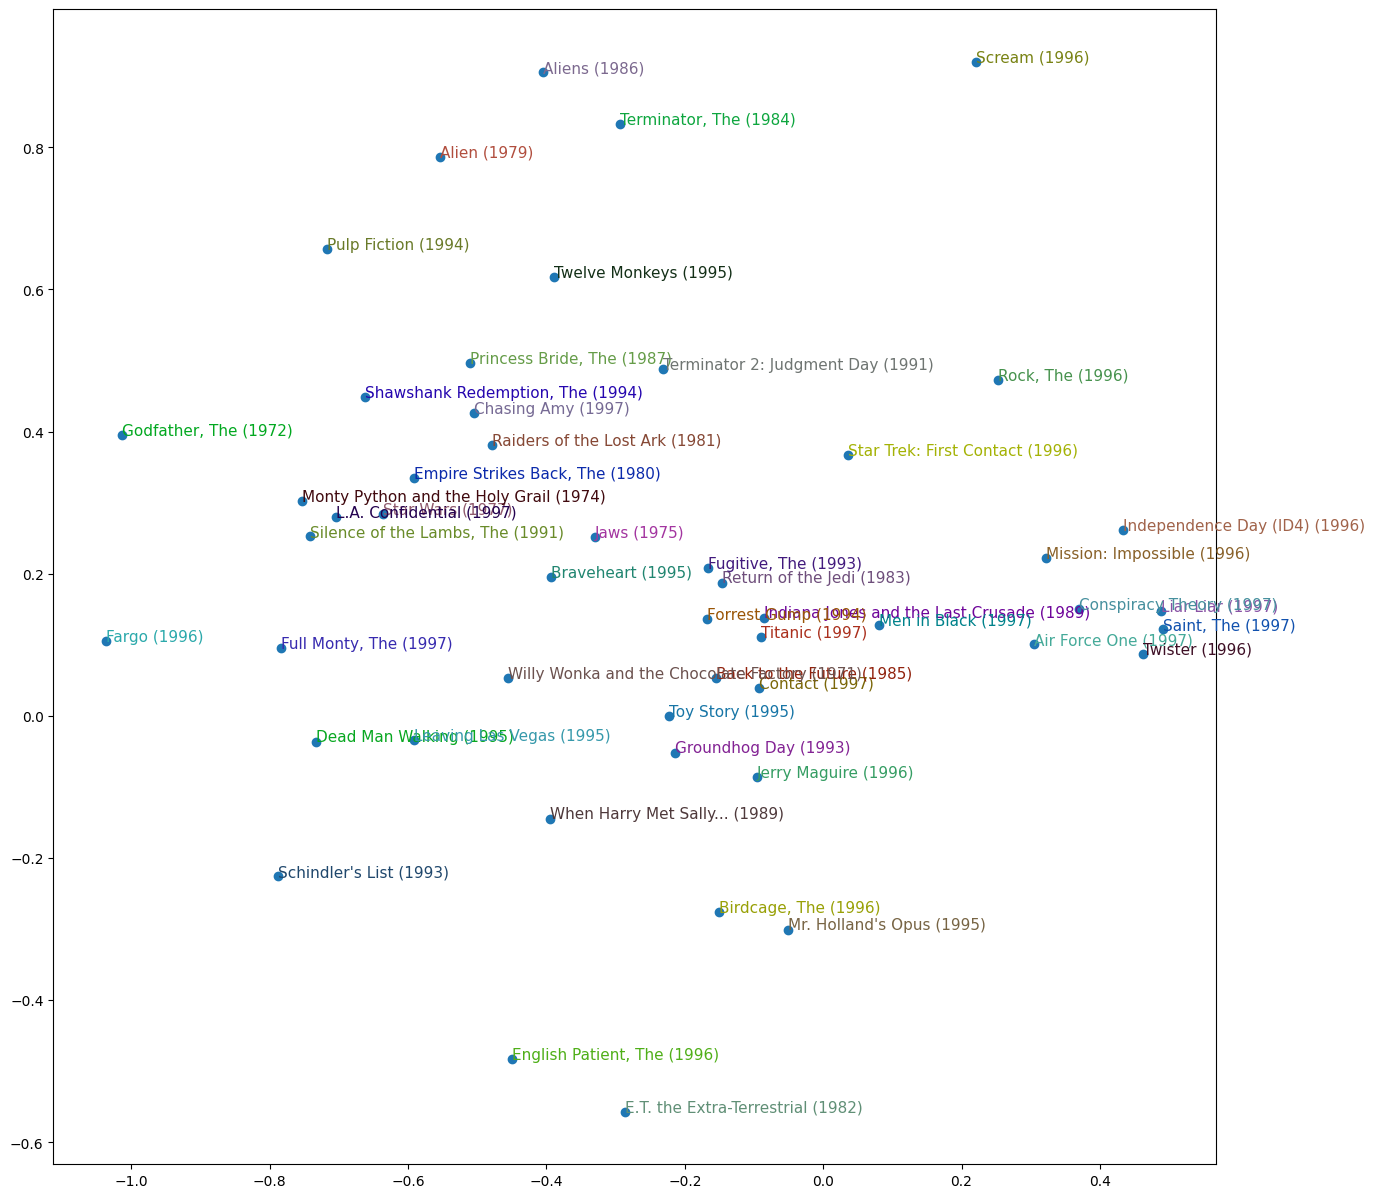

In [53]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [54]:



# Install fastai if not already installed
!pip install fastai --quiet

# Import necessary FastAI modules
from fastai.collab import collab_learner, CollabDataLoaders
from fastai.data.all import *
import time
import numpy as np
import pandas as pd

# Load MovieLens dataset
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
path = untar_data(url)  # FastAI automatically downloads and extracts
ratings_path = path / 'ratings.csv'

# Read the ratings data
ratings = pd.read_csv(ratings_path)

# Display the first few rows
print("Sample Ratings Data:")
print(ratings.head())

# Check column names
assert {'userId', 'movieId', 'rating'}.issubset(ratings.columns), "Dataset is missing required columns!"

# Create DataLoaders
dls = CollabDataLoaders.from_df(ratings, item_name='movieId', user_name='userId', rating_name='rating')

# Define RMSE calculation function
def calculate_rmse(learn, data_loader):
    preds, _ = learn.get_preds(dl=data_loader)
    true_values = data_loader.items['rating'].values  # Extract true ratings
    rmse = np.sqrt(((preds.numpy().flatten() - true_values) ** 2).mean())  # Compute RMSE
    return rmse

# Experiment with different values for n_factors (latent factors)
n_factors_list = [10, 20, 50, 100]  # Number of latent factors to test

# Store results
results = []

for n_factors in n_factors_list:
    print(f"\nTraining model with n_factors = {n_factors}...")

    # Create and train model
    learn = collab_learner(dls, n_factors=n_factors, y_range=(0, 5.5))

    # Record training time
    start_time = time.time()
    learn.fit_one_cycle(5, 5e-3, wd=0.1)  # Train for 5 epochs
    end_time = time.time()

    training_time = end_time - start_time  # Calculate training time
    rmse = calculate_rmse(learn, dls.valid)  # Compute RMSE

    # Store results
    results.append({'n_factors': n_factors, 'training_time': training_time, 'rmse': rmse})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)





Sample Ratings Data:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Training model with n_factors = 10...


epoch,train_loss,valid_loss,time
0,0.777098,0.817618,00:08
1,0.663934,0.752438,00:08
2,0.591228,0.731091,00:08
3,0.540844,0.720552,00:08
4,0.540852,0.718098,00:08



Training model with n_factors = 20...


epoch,train_loss,valid_loss,time
0,0.796706,0.817284,00:08
1,0.605869,0.759495,00:08
2,0.518345,0.747642,00:09
3,0.478195,0.732956,00:08
4,0.460943,0.730716,00:08



Training model with n_factors = 50...


epoch,train_loss,valid_loss,time
0,0.740287,0.813867,00:08
1,0.474872,0.776440,00:08
2,0.372061,0.753881,00:08
3,0.278394,0.738330,00:08
4,0.273414,0.735153,00:08



Training model with n_factors = 100...


epoch,train_loss,valid_loss,time
0,0.689210,0.821034,00:08
1,0.410306,0.773134,00:08
2,0.293942,0.760340,00:10
3,0.180385,0.742290,00:12
4,0.163872,0.739131,00:08



Results Summary:
   n_factors  training_time      rmse
0         10      43.489928  0.847406
1         20      43.520905  0.854819
2         50      43.229682  0.857411
3        100      47.396906  0.859727


# Exercise 2

## Play around with different collaborative filtering model parameters such as n_factors and other parameters.
## Identify if any such parameters have impact on the speed of convergence or the performance on the model

In [55]:

# Install fastai if not already installed
!pip install fastai --quiet

# Import necessary FastAI modules
from fastai.collab import collab_learner, CollabDataLoaders
from fastai.data.all import *
import time
import numpy as np
import pandas as pd

# Load MovieLens dataset
path = untar_data(URLs.ML_100k)  # FastAI provides predefined URL for MovieLens dataset
ratings_path = path / 'u.data'

# Read the ratings data
ratings = pd.read_csv(ratings_path, sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])

# Drop timestamp as it's not needed
ratings.drop(columns=['timestamp'], inplace=True)

# Display the first few rows
print("Sample Ratings Data:")
print(ratings.head())

# Check column names
assert {'userId', 'movieId', 'rating'}.issubset(ratings.columns), "Dataset is missing required columns!"

# Create DataLoaders
dls = CollabDataLoaders.from_df(ratings, item_name='movieId', user_name='userId', rating_name='rating', bs=64)

# Display DataLoaders information
print("\nDataLoaders Info:")
print(dls)

# Define RMSE calculation function
def calculate_rmse(learn, dls):
    # Get predictions and true values
    preds, targs = learn.get_preds(dl=dls.valid)

    # Compute RMSE
    rmse = np.sqrt(((preds.numpy().flatten() - targs.numpy()) ** 2).mean())
    return rmse

# Experiment with different values for n_factors (latent factors)
n_factors_list = [10, 20, 50, 100]  # Number of latent factors to test

# Store results
results = []

for n_factors in n_factors_list:
    print(f"\nTraining model with n_factors = {n_factors}...")

    # Create and train model
    learn = collab_learner(dls, n_factors=n_factors, y_range=(0, 5.5))

    # Record training time
    start_time = time.time()
    learn.fit_one_cycle(5, 5e-3, wd=0.1)  # Train for 5 epochs
    end_time = time.time()

    training_time = end_time - start_time  # Calculate training time
    rmse = calculate_rmse(learn, dls)  # Compute RMSE

    # Store results
    results.append({'n_factors': n_factors, 'training_time': training_time, 'rmse': rmse})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)

Sample Ratings Data:
   userId  movieId  rating
0     196      242       3
1     186      302       3
2      22      377       1
3     244       51       2
4     166      346       1

DataLoaders Info:

Training model with n_factors = 10...


epoch,train_loss,valid_loss,time
0,0.940808,0.959151,00:08
1,0.795511,0.887996,00:08
2,0.763972,0.866074,00:08
3,0.726177,0.848677,00:08
4,0.738943,0.844212,00:08



Training model with n_factors = 20...


epoch,train_loss,valid_loss,time
0,0.916673,0.963517,00:08
1,0.762735,0.899342,00:08
2,0.740195,0.863135,00:10
3,0.671543,0.844920,00:08
4,0.650209,0.839310,00:08



Training model with n_factors = 50...


epoch,train_loss,valid_loss,time
0,0.882758,0.951392,00:08
1,0.679438,0.897962,00:08
2,0.531750,0.873280,00:08
3,0.445585,0.855025,00:08
4,0.449336,0.851311,00:08



Training model with n_factors = 100...


epoch,train_loss,valid_loss,time
0,0.849677,0.945269,00:08
1,0.572006,0.912634,00:07
2,0.391167,0.883885,00:08
3,0.301826,0.869555,00:09
4,0.289613,0.865663,00:08



Results Summary:
   n_factors  training_time      rmse
0         10      43.812108  1.280573
1         20      44.922802  1.291488
2         50      42.910884  1.308808
3        100      43.457814  1.316838
